In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

In [5]:
dataset_path = 'skin_cancer_test'


In [6]:
datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images in smaller batches
batch_size = 16
image_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  # Since it's binary classification
    shuffle=False
)

image_data = []
labels = []

# Iterate over batches to load and process images incrementally
for i in range(len(image_generator)):
    batch_images, batch_labels = image_generator[i]
    image_data.extend(batch_images)
    labels.extend(batch_labels)

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print("Image Data Shape:", image_data.shape)
print("Labels Shape:", labels_encoded.shape)

Found 2000 images belonging to 2 classes.
Image Data Shape: (2000, 224, 224, 3)
Labels Shape: (2000,)


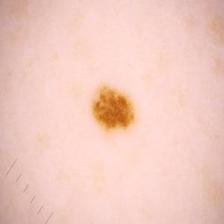

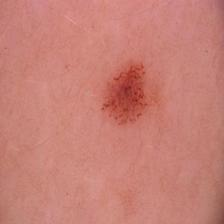

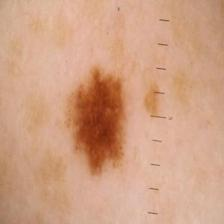

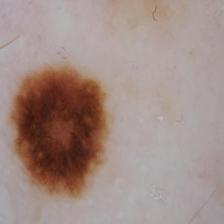

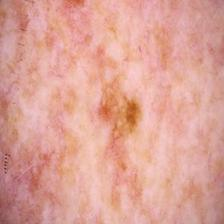

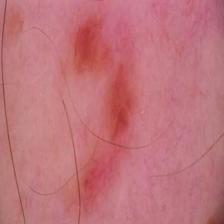

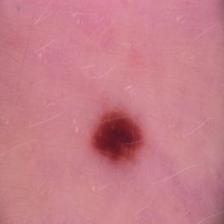

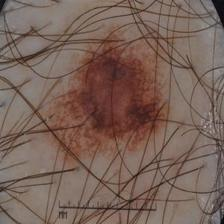

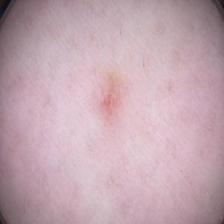

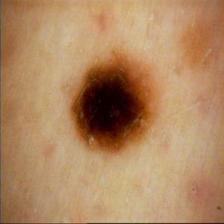

In [7]:
import os
from IPython.display import Image

image_dir = 'skin_cancer_test/Benign/'

# List all image file names in the directory
image_files = os.listdir(image_dir)

# Display each image
for filename in image_files[:10]:
    image_path = os.path.join(image_dir, filename)
    display(Image(filename=image_path))

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)

Training Data Shape: (1600, 224, 224, 3)
Testing Data Shape: (400, 224, 224, 3)
Training Labels Shape: (1600,)
Testing Labels Shape: (400,)


In [9]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Fix the warning by using the recommended Input layer
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))

# Try a different optimizer with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# For performance issues, try:
# 1. Use a smaller batch size if you're having memory issues
# 2. Reduce input size if possible
# 3. Check if you can use CPU-only mode if GPU is causing problems
history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

model.save('skin_cancer_detection_model.keras')

Epoch 1/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.5710 - loss: 0.6770 - val_accuracy: 0.8531 - val_loss: 0.4831
Epoch 2/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.7594 - loss: 0.5197 - val_accuracy: 0.8594 - val_loss: 0.3453


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
model = tf.keras.models.load_model('skin_cancer_detection_model.keras')
y_pred = model.predict(X_test)

y_pred_binary = np.round(y_pred)

precision = precision_score(y_test, y_pred_binary)

recall = recall_score(y_test, y_pred_binary)

f1 = f1_score(y_test, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Precision: 0.8636363636363636
Recall: 0.7562189054726368
F1 Score: 0.8063660477453581


In [14]:
from skimage import io, transform
import numpy as np

image_path = 'skin_cancer_test/Benign/6327.jpg'

img = io.imread(image_path)
input_image = transform.resize(img, (224, 224), anti_aliasing=True)
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

predicted = model.predict(input_image)[0][0]
predicted_binary = round(predicted)
decoded_class = 'Benign' if predicted_binary == 0 else 'Malignant'

print("Predicted Class:", decoded_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted Class: Malignant
